# Chapter 5. How do I build a model to predict a quantitative variable?

Prediction problems are ubiquitous in real world applications. For example:

- A real estate agent might want to predict the fair price of a home, using features about the home.
- A sports bettor might want to predict which team will win the game, using information about the teams.
- A historian might want to predict which historical figure wrote an anonymous document, using the words in the document.

In each case, we have **features**, such as square footage and number of bedrooms, that we want to use to predict a **label**, such as house price. We can formalize the problem mathematically as follows: let $X$ be the features and $y$ the label; a **predictive model** is a function $f$ that maps $X$ to $y$:

$$ f: X \mapsto y. $$

Now suppose we have a new house, with features $X^*$. A predictive model $f$ predicts the price of this house to be $f(X^*)$.

How do we come up a predictive model $f$ in the first place? One way is to learn it from existing data, or **training data**. The training data consists of features and the corresponding labels. For example, to build a model to predict the price of a home using the square footage (`Gr Liv Area`), we would need training data like the points shown in black below.

<img src="predictive_model.png" />

We could then learn a model, $f$, from this training data. For example, one possible predictive model is the red curve shown in the plot. This model was chosen to fit the points in the training data as closely as tightly. If we wanted to predict the price of a 2700 square foot home using this model, we would simply evaluate $f(2700)$, which comes out to about \$300,000. The key thing to note is that $f$ depends on the training data. If the training data changes, then so does $f$.

The field that studies how to learn predictive models from data is known as **machine learning**. There are many algorithms for learning predictive models from data, including _linear regression_ (which you may be familiar with from a statistics course), _decision trees_, and _neural networks_. In this chapter, we will focus on one machine learning algorithm called **k-nearest neighbors** that leverages the distance metrics that you learned about in the previous chapter.

Predictive models are classified into two types, depending on whether the label $y$ is categorical or quantitative. If the label is quantitative, then the model is called a **regressor**. If the label is categorical, then the model is called a **classifier**. Chapter 5 covers regression models, while Chapter 6 covers classification models.

# Chapter 5.1 K-Nearest Neighbors for Regression

_Regression models_ are used to predict labels that are quantitative. In this section, we will train a machine learning model that predicts the price of a house from its square footage and other features.

We will use the Ames housing data set as the training data. First, let's read in the data set.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.display.max_rows = 5

housing = pd.read_csv("/data301/data/AmesHousing.txt", sep="\t")
housing

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000
2929,2930,924151050,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,188000


Let's focus on just two features for now: square footage (of the dwelling) and the number of bedrooms. Let's plot the training data, using a color gradient to represent the labels. Notice how we can customize the color gradient using the `cmap=` argument. A list of the available colormaps can be found [here](https://matplotlib.org/examples/color/colormaps_reference.html).

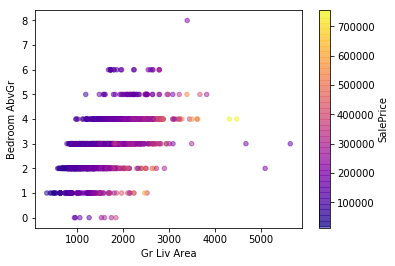

In [2]:
housing.plot.scatter(x="Gr Liv Area", y="Bedroom AbvGr", 
                     c="SalePrice", cmap="plasma", alpha=.5,
                     sharex=False);  
# sharex=False is a workaround for a Pandas bug
# (https://github.com/pandas-dev/pandas/issues/10678)

Notice how points that are close on this plot tend to have similar house prices. This insight is the basis of the $k$-nearest neighbors algorithm for predicting house prices. Suppose that we want to predict the price of a 4000 square foot home with 3 bedrooms, represented by a black circle on the plot below.

<img src="regression.png" />

We can find the $k$ points that are closest to this point in feature space and average their prices as our prediction. For example, the 30-nearest neighbors in the training data to the new home are illustrated in the plot below. We would average the prices of these 30 homes to obtain the predicted price for the new home.

<img src="regression_neighbors.png" />

The $k$-nearest neighbors regression algorithm can be summarized as follows:

1. Determine the $k$ closest points in the training data to the new point that you want to predict for, based on some distance metric on the features.
2. The predicted label of the new point is the mean (or median) of the labels of the $k$ closest points.

Let's see how to implement this in code. First, we extract the training data and standardize the features:

In [3]:
X_train = housing[["Gr Liv Area", "Bedroom AbvGr"]]
y_train = housing["SalePrice"]

X_train_std = (X_train - X_train.mean()) / X_train.std()

Then, we create a `Series` for the new house, standardizing it in the exact same way:

In [4]:
x_new = pd.Series()
x_new["Gr Liv Area"] = 4000
x_new["Bedroom AbvGr"] = 3

x_new_std = (x_new - X_train.mean()) / X_train.std()

Now we calculate the (Euclidean) distances between this new house and each house in the training data. Then, we sort the distances.

In [5]:
dists = np.sqrt(((X_train_std - x_new_std) ** 2).sum(axis=1))
dists_sorted = dists.sort_values()
dists_sorted

1306    1.002950
2181    1.337266
          ...   
1302    7.507162
1901    7.644028
dtype: float64

The first 30 entries of this sorted list are the 30 nearest neighbors. Let's get their indices.

In [6]:
i_nearest = dists_sorted.index[:30]
i_nearest

Int64Index([1306, 2181, 1767, 2445, 2666, 1760, 2450, 1537, 2045,   15,   65,
            1772,  565, 2214,  422, 2336, 1182, 2570, 1945, 1764, 2500, 2453,
            2329, 1320, 1497, 2180, 1572, 2737, 2218, 1022],
           dtype='int64')

Now we can look up these indices in the original data.

In [7]:
housing.loc[i_nearest]

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1306,1307,902207220,75,RM,87.0,18386,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,295000
2181,2182,908154205,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2218,2219,909281130,70,RL,70.0,10570,Pave,NaN,Reg,Bnk,...,0,NaN,NaN,NaN,0,12,2007,WD,Normal,315000
1022,1023,527325070,60,RL,NaN,12227,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,272000


To make a prediction for the price of this new house, we average the sale prices of these 30 nearest neighbors.

In [8]:
y_train.loc[i_nearest].mean()

382429.23333333334

So the model predicts that the house is worth $382,429.

## A More Complex Model

The model above only had two features so it was easy to visualize the "nearest neighbors" on the scatterplot. But the magic of $k$-nearest neighbors is that it still works when there are more features and the data isn't so easy to visualize.

In [76]:
# Create a new variable
housing["Date Sold"] = housing["Yr Sold"] + housing["Mo Sold"] / 12
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built", "Date Sold",
            "Neighborhood"]

# Note that "Neighborhood" is a categorical variable.
X_train = pd.get_dummies(housing[features])
y_train = housing["SalePrice"]

Suppose an assessor is trying to predict the fair value in 2011 of a 1400-square foot home built in 1980 with 3 bedrooms, 2 full baths, and 1 half bath, on a 9000 square-foot lot in the `OldTown` neighborhood. Let's create the `pandas` `Series` corresponding to this house. Remember that we have dummy variables for each neighborhood. We have to be sure to include these dummy variables in the new `Series` as well. The easiest way to do this is to initialize the index of the `Series` to match the columns of `X_train` above.

In [10]:
X_train.columns

Index(['Lot Area', 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Year Built', 'Date Sold', 'Neighborhood_Blmngtn',
       'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens',
       'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker'],
      dtype='object')

In [11]:
# Initialize a Series of NaNs, indexed by the columns of X_train
x_new = pd.Series(index=X_train.columns)

# Set the values of the known variables.
x_new["Lot Area"] = 9000
x_new["Gr Liv Area"] = 1400
x_new["Full Bath"] = 2
x_new["Half Bath"] = 1
x_new["Bedroom AbvGr"] = 3
x_new["Year Built"] = 1980
x_new["Date Sold"] = 2011

# This house is in Old Town, so its dummy variable has value 1.
x_new["Neighborhood_OldTown"] = 1
# The dummy variables for the other neighborhoods all have value 0.
x_new.fillna(0, inplace=True)

x_new

Lot Area                9000.0
Gr Liv Area             1400.0
                         ...  
Neighborhood_Timber        0.0
Neighborhood_Veenker       0.0
dtype: float64

Now we can implement $k$-nearest neighbors much as we did above.

In [12]:
# Standardize the variables.
X_train_std = (X_train - X_train.mean()) / X_train.std()
x_new_std = (x_new - X_train.mean()) / X_train.std()

# Find index of 30 nearest neighbors.
dists = np.sqrt(((X_train_std - x_new_std) ** 2).sum(axis=1))
i_nearest = dists.sort_values()[:30].index

# Average the labels of these 30 nearest neighbors
y_train.loc[i_nearest].mean()

132343.33333333334

So the model predicts that this house is worth \$132,343.

## The K-Nearest Neighbors Regression Function

Remember that a predictive model is defined as a function $f: X \mapsto y$. We can visualize $f$ when $X$ consists of a single feature, like square footage. We saw a hypothetical model in Figure 5.* above. How does $f$ look for a $k$-nearest neighbors regression model?

First, we extract the training data.

In [ ]:
X_train = housing[["Gr Liv Area"]]
y_train = housing["SalePrice"]

In order to plot $f$, we need to evaluate the predictive model at a grid of $X$ values. Since square footage varies from 0 to 6000 square feet in the training data, we create a grid of $X$ values from 0 to 6000, in increments of 10.

In [ ]:
X_new = pd.DataFrame()
X_new["Gr Liv Area"] = np.arange(0, 6000, 10)
X_new

Next, we will define a function `get_30NN_prediction` that implements the 30-nearest neighbor algorithm above: given a new observation, it returns the mean label of the 30-nearest neighbors to that observation.

In [ ]:
def get_30NN_prediction(x_new):
    """Given a new observation, returns the k-nearest neighbors prediction
    """
    dists = ((X_train - x_new) ** 2).sum(axis=1)
    inds_sorted = dists.sort_values().index[:30]
    return y_train.loc[inds_sorted].mean()

We actually have 600 new observations in `X_new`. Let's apply this function to each new observation.

In [ ]:
y_new_pred = X_new.apply(get_30NN_prediction, axis=1)
y_new_pred

We want to plot these predictions as a curve (`.plot.line()`). `pandas` will plot the index of the `Series` on the `x`-axis, so we have to set the index appropriately.

In [ ]:
y_new_pred.index = X_new
y_new_pred.plot.line()

Now let's put all the pieces together and overlay this regression function on top of a scatterplot of the training data.

In [ ]:
# Make a scatterplot of the training data
housing.plot.scatter(x="Gr Liv Area", y="SalePrice", color="black", alpha=.2)

# Add the predictions as a red line on this scatterplot
y_new_pred.plot.line(color="red")

Notice how rough the 30-nearest neighbors regression function looks. In particular, look at the right half of the graph where the training data is sparse. The regression function is a step function in this range. That is because the value of the prediction changes only when the identities of the 30-nearest neighbors change. Houses with a square footage between 4500 and 6000 all have the same 30 nearest neighbors in the training data, so the prediction is constant in that range.

# Exercises

**Exercise 1.** Plot the $k$-nearest neighbors regression function for predicting sale price from just its square footage for $k=5, 30, 100$. How does the regression function change as $k$ increases?

In [ ]:
# TYPE YOUR CODE HERE

**Exercise 2.** Build a $k$-nearest neighbors model to predict how much tip a person will pay, using the Tips dataset (`/data301/data/tips.csv`) as your training data. Use your model to predict how much a male diner will tip on a bill of \$40.00 on a Sunday.

In [ ]:
# TYPE YOUR CODE HERE

**Challenge Exercise.** We visualized the $k$-nearest neighbors regression function above, in the special case where there is only one feature. It is also possible to visualize a regression function in the case where there are two features, using a heat map, where the two axes represent the two features and the color represents the label.

Make a heat map that shows the 30-nearest neighbors regression function when there are two features in the model: square footage (`Gr Liv Area`) and number of bedrooms (`Bedroom AbvGr`).

In [ ]:
# TYPE YOUR CODE HERE